In [37]:
import os
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from neo4j import GraphDatabase
from tqdm import tqdm

In [5]:
# Setup Neo4j connection
driver = GraphDatabase.driver("bolt://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))

def run_query(tx, query, parameters=None):
    tx.run(query, parameters or {})

def run_cypher(query):
    with driver.session() as session:
        return list(session.run(query))

def run_write_cypher(query):
    with driver.session() as session:
        session.run(query)

# Load DataFrames
report_df = pd.read_csv("data/nodes_report.csv")
temp_df = pd.read_csv("data/edges_temporal.csv")
borders_df = pd.read_csv("data/edges_borders.csv")

In [9]:
df = report_df

# 1) pivot_table with columns = [year, week]
pivot_df = df.pivot_table(
    index='location_id',
    columns=['year','week'],
    values='cases_current_week',
    aggfunc='first'   # or 'sum' if you suspect duplicates
)

print("Pivoted shape:", pivot_df.shape)
pivot_df.head()


Pivoted shape: (55, 169)


year          2022                                                          \
week            1      2      3      4      5      6      7      8      9    
location_id                                                                  
ALABAMA      333.0  114.0   75.0    NaN   62.0  213.0  196.0  531.0  521.0   
ALASKA         NaN    NaN    NaN    NaN    NaN    NaN    NaN   43.0   52.0   
ARIZONA      347.0  365.0    NaN  471.0  460.0  478.0  467.0  430.0  488.0   
ARKANSAS     123.0    NaN  102.0  157.0   90.0  200.0  167.0  103.0  167.0   
CALIFORNIA   235.0    NaN    NaN    NaN  640.0    NaN  341.0    NaN    NaN   

year                ...    2025                                          \
week            10  ...      5       6       7       8       9       10   
location_id         ...                                                   
ALABAMA      591.0  ...   598.0   594.0   592.0   551.0   563.0   569.0   
ALASKA         NaN  ...    29.0    34.0    29.0    39.0    32.0    24.0   
ARIZONA      495.0  ...     NaN   299.0   332.0   310.0   350.0   351.0   
ARKANSAS     139.0  ...   185.0   172.0   158.0   104.0   230.0   215.0   
CALIFORNIA     NaN  ...  1831.0  1983.0  1612.0  1757.0  2047.0  2048.0   

year                                         
week             11      12      13      14  
location_id                                  
ALABAMA       501.0   558.0   508.0   549.0  
ALASKA         45.0    59.0    37.0    54.0  
ARIZONA         NaN   283.0   385.0   370.0  
ARKANSAS      168.0   194.0   142.0   207.0  
CALIFORNIA   2008.0  1994.0  2020.0  2012.0  

[5 rows x 169 columns]

In [10]:
pivot_df_filled = pivot_df.fillna(0)
pivot_df_filled = pivot_df.apply(lambda row: row.fillna(row.mean()), axis=1)

In [11]:
# Step 1: handle NaNs
pivot_df_filled = pivot_df.fillna(0)  # if zero fill is acceptable

# Step 2: correlation among locations (rows)
corr_matrix = pivot_df_filled.T.corr()  
# This yields a square matrix with index=locations, columns=locations, values=Pearson r


In [12]:
THRESHOLD = 0.3
edges = []
for locA in corr_matrix.index:
    for locB in corr_matrix.columns:
        if locA < locB:  # avoiding duplicating locA->locB and locB->locA
            r = corr_matrix.loc[locA, locB]
            if r >= THRESHOLD:
                edges.append((locA, locB, r))

df_edges = pd.DataFrame(edges, columns=["state1", "state2", "weight"])
print("Number of edges after threshold:", len(df_edges))
df_edges.head()


Number of edges after threshold: 139


,state1,state2,weight
0,ALABAMA,ALASKA,0.381976
1,ALABAMA,CALIFORNIA,0.507862
2,ALABAMA,FLORIDA,0.329587
3,ALABAMA,INDIANA,0.371377
4,ALABAMA,IOWA,0.379585


In [13]:
df_edges.to_csv("data/infection_edges.csv", index=False)

In [17]:
# Example structure:
#   state1   state2   weight
# 0 ALABAMA  TENNESSEE  0.64
# 1 ALABAMA  MISSISSIPPI 0.75
# etc.

query = """
MATCH (l1:Location {id: $locA}), (l2:Location {id: $locB})
MERGE (l1)-[r:SIMILAR_INFECTION]->(l2)
SET r.weight = $weight
"""

with driver.session() as session:
    # Insert each row's edge directly into Neo4j
    for idx, row in df_edges.iterrows():
        session.run(
            query, 
            {
                "locA": row["state1"],
                "locB": row["state2"],
                "weight": float(row["weight"])
            }
        )

print("Created SIMILAR_INFECTION relationships with 'weight' from df_edges in Neo4j!")


Created SIMILAR_INFECTION relationships with 'weight' from df_edges in Neo4j!


In [19]:
# Creating the GDS 'infection_graph' and run the 3 algorithms

with driver.session() as session:
    # 1) Creating the infection_graph in GDS
    create_graph_q = """
    CALL gds.graph.project(
      'infection_graph',
      ['Location'],
      {
        SIMILAR_INFECTION: {
          type: 'SIMILAR_INFECTION',
          orientation: 'UNDIRECTED',
          properties: 'weight'
        }
      }
    )
    """
    session.run(create_graph_q)
    print("Created 'infection_graph' in GDS using SIMILAR_INFECTION edges.")

    # 2) Running Louvain
    louvain_q = """
    CALL gds.louvain.stream('infection_graph', {
      relationshipWeightProperty: 'weight'
    })
    YIELD nodeId, communityId
    RETURN gds.util.asNode(nodeId).id AS location_id, communityId
    ORDER BY communityId
    """
    louvain_data = session.run(louvain_q).data()
    print("LOUVAIN RESULTS (first 5 rows):", louvain_data[:5])

    # 3) Running Betweenness Centrality
    betweenness_q = """
    CALL gds.betweenness.stream('infection_graph', {
      relationshipWeightProperty: 'weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).id AS location_id, score
    ORDER BY score DESC
    """
    betweenness_data = session.run(betweenness_q).data()
    print("BETWEENNESS RESULTS (top 5):", betweenness_data[:5])

    # 4) Running PageRank
    pagerank_q = """
    CALL gds.pageRank.stream('infection_graph', {
      relationshipWeightProperty: 'weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).id AS location_id, score
    ORDER BY score DESC
    """
    pagerank_data = session.run(pagerank_q).data()
    print("PAGERANK RESULTS (top 5):", pagerank_data[:5])


Created 'infection_graph' in GDS using SIMILAR_INFECTION edges.
LOUVAIN RESULTS (first 5 rows): [{'location_id': 'VERMONT', 'communityId': 2}, {'location_id': 'NEW JERSEY', 'communityId': 3}, {'location_id': 'NEBRASKA', 'communityId': 11}, {'location_id': 'SOUTH DAKOTA', 'communityId': 12}, {'location_id': 'GEORGIA', 'communityId': 14}]
BETWEENNESS RESULTS (top 5): [{'location_id': 'CALIFORNIA', 'score': 106.0}, {'location_id': 'MICHIGAN', 'score': 102.0}, {'location_id': 'ARKANSAS', 'score': 76.0}, {'location_id': 'NORTH DAKOTA', 'score': 75.0}, {'location_id': 'MISSOURI', 'score': 73.0}]
PAGERANK RESULTS (top 5): [{'location_id': 'CALIFORNIA', 'score': 2.2717276244727325}, {'location_id': 'WISCONSIN', 'score': 1.9947024759744436}, {'location_id': 'MICHIGAN', 'score': 1.930325076021792}, {'location_id': 'ALABAMA', 'score': 1.8368092945671752}, {'location_id': 'IOWA', 'score': 1.6786061836285333}]


Number of nodes in the similarity graph: 42
Number of edges in the similarity graph: 139


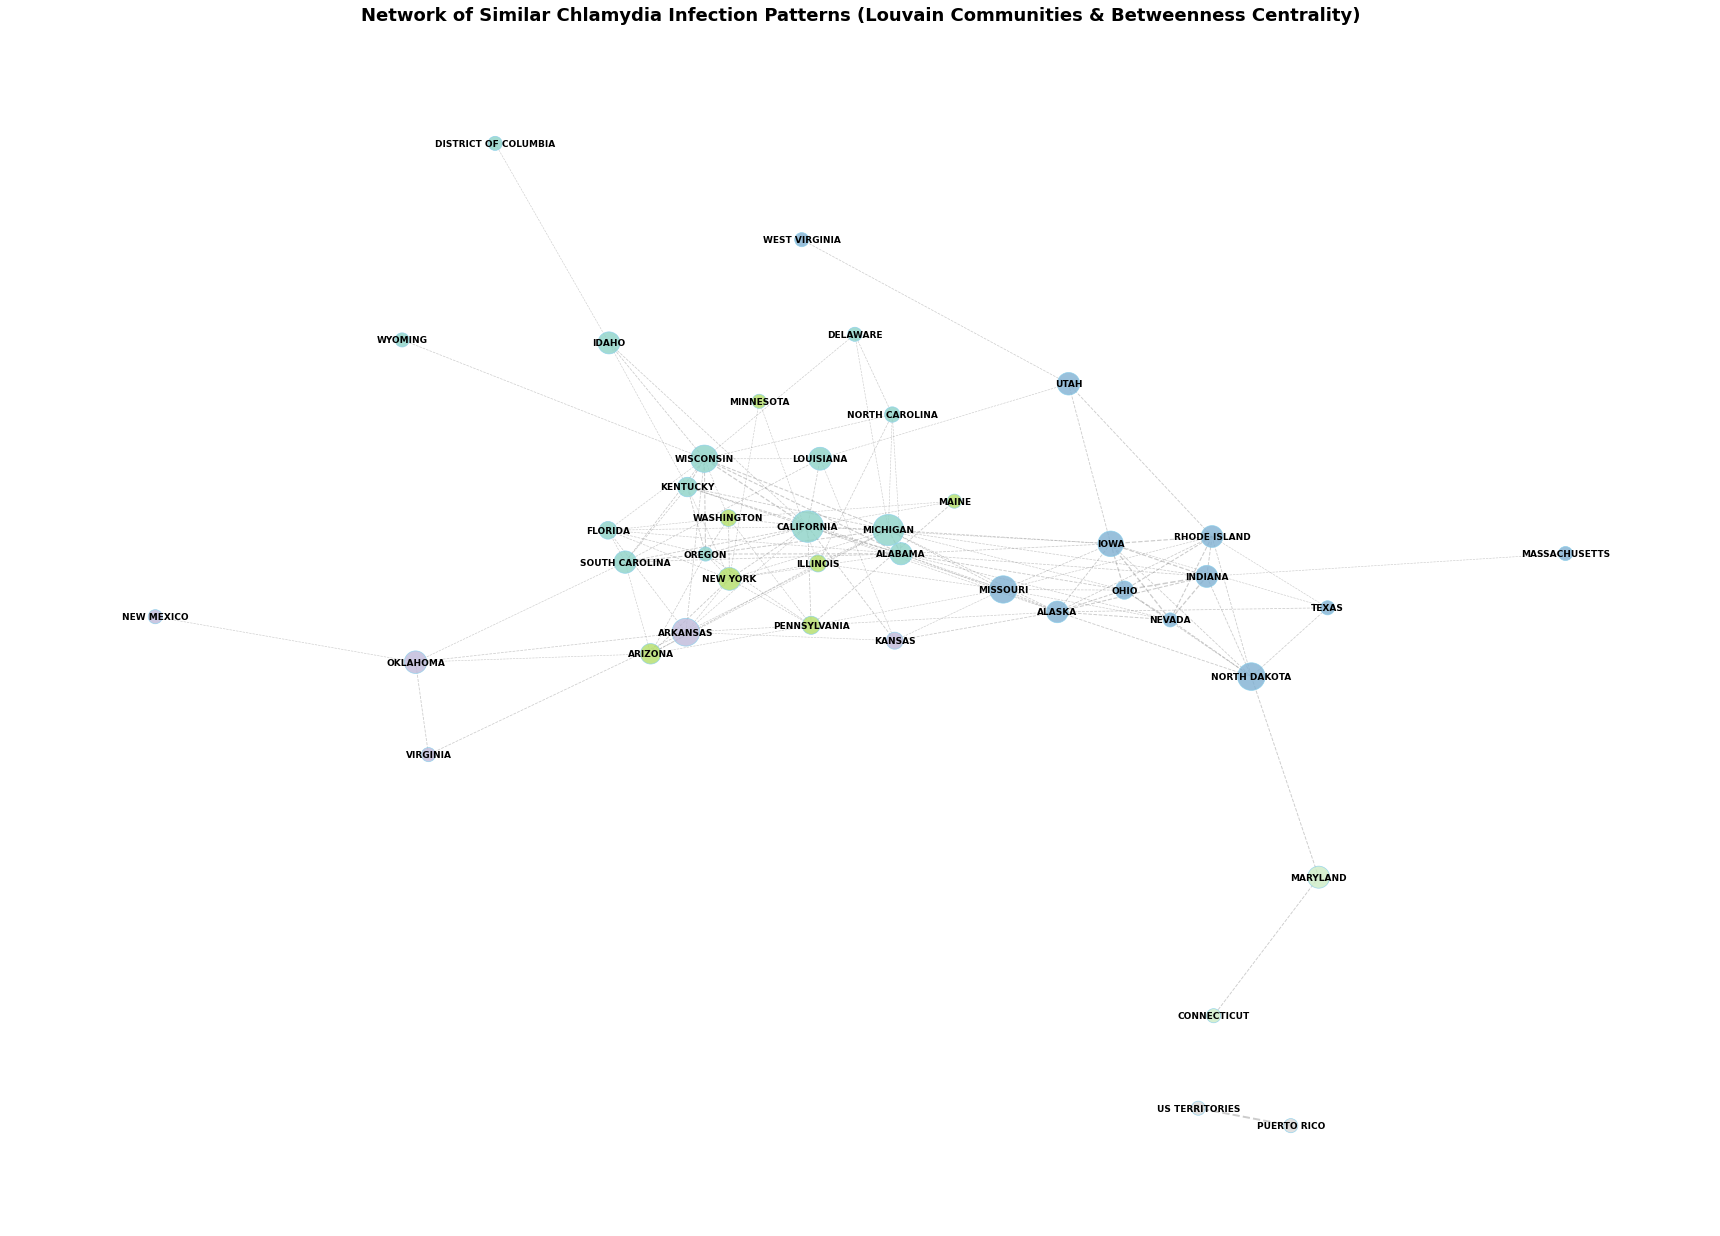

Done! Visualized network of similar infection patterns (colored by Louvain community, sized by Betweenness).


In [58]:
# Converting them to dictionaries for easy lookup
dict_louvain = {row["location_id"]: row["communityId"] for row in louvain_data}
dict_betweenness = {row["location_id"]: row["score"] for row in betweenness_data}
dict_pagerank = {row["location_id"]: row["score"] for row in pagerank_data}


# Assuming 'driver' is your Neo4j driver instance and connected

# 1. Fetching Similar Infection Edges from Neo4j
edge_query = """
MATCH (l1:Location)-[r:SIMILAR_INFECTION]->(l2:Location)
RETURN l1.id AS stateA, l2.id AS stateB, r.weight AS weight
"""

with driver.session() as session:
    edge_data = session.run(edge_query).data()

# 2. Building the Infection Similarity Graph in NetworkX
infection_similarity_graph = nx.Graph()

for row in edge_data:
    state_a = row["stateA"]
    state_b = row["stateB"]
    similarity_weight = row["weight"]
    infection_similarity_graph.add_edge(state_a, state_b, weight=similarity_weight)

print(f"Number of nodes in the similarity graph: {infection_similarity_graph.number_of_nodes()}")
print(f"Number of edges in the similarity graph: {infection_similarity_graph.number_of_edges()}")


# Creating node attributes for community, betweenness, and pagerank
for node in infection_similarity_graph.nodes():
    infection_similarity_graph.nodes[node]["community"] = dict_louvain.get(node, -1)
    infection_similarity_graph.nodes[node]["betweenness"] = dict_betweenness.get(node, 0.0)
    infection_similarity_graph.nodes[node]["pagerank"] = dict_pagerank.get(node, 0.0)

# 3. Defining Colors for Louvain Communities
communities = [infection_similarity_graph.nodes[n]["community"] for n in infection_similarity_graph.nodes()]
unique_communities = sorted(set(communities))

base_colormap = cm.Set3  # Choose a visually appealing colormap
community_color_map = {}
for i, community_id in enumerate(unique_communities):
    if community_id == -1:
        community_color_map[community_id] = mcolors.to_rgba("lightgray")  # For unassigned nodes
    else:
        community_color_map[community_id] = base_colormap(i / len(unique_communities)) # Normalize color mapping

node_colors = [community_color_map[c] for c in communities]

# 4. Defining Node Sizes by Betweenness Centrality
betweenness_values = [infection_similarity_graph.nodes[n]["betweenness"] for n in infection_similarity_graph.nodes()]
min_bet = min(betweenness_values)
max_bet = max(betweenness_values)

# Scaling betweenness to a reasonable node size range
node_sizes = [(val - min_bet) / (max_bet - min_bet) * 800 + 200 for val in betweenness_values]

# 5. Graphing Layout
layout_position = nx.spring_layout(infection_similarity_graph, k=0.3, seed=42)

# 6. Visualizing with Enhanced Presentation
plt.figure(figsize=(24, 18))  # Adjusting figure size for better readability

# Drawing edges (representing similarity)
nx.draw_networkx_edges(
    infection_similarity_graph,
    layout_position,
    edge_color="gray",
    alpha=0.4,
    width=[d['weight'] * 2 for u, v, d in infection_similarity_graph.edges(data=True)], # Weight-based edge thickness
    style="dashed" # Indicating the nature of the edge (similarity, not direct infection)
)

# Drawing nodes (colored by community, sized by betweenness)
nodes = nx.draw_networkx_nodes(
    infection_similarity_graph,
    layout_position,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="skyblue",
    linewidths=0.7,
    alpha=0.8
)

# Drawing node labels (state abbreviations)
nx.draw_networkx_labels(
    infection_similarity_graph,
    layout_position,
    font_size=9,
    font_weight="bold"
)

# 7. Title and Annotations for Clarity
plt.title(
    "Network of Similar Chlamydia Infection Patterns (Louvain Communities & Betweenness Centrality)",
    fontsize=18,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Nodes colored by Louvain Community; Size proportional to Betweenness Centrality. Dashed edges represent similarity in infection patterns (thickness indicates strength).", fontsize=12)

# 8. Legend for Communities
community_labels = {id: f"Community {id}" if id != -1 else "Unassigned" for id in unique_communities}
legend_handles = [plt.plot([], [], marker="o", markersize=10, linestyle="none", color=community_color_map[id], label=label)[0]
                  for id, label in community_labels.items()]
#plt.legend(handles=legend_handles, title="Louvain Communities", fontsize=10, loc="upper left", bbox_to_anchor=(1.02, 1))

# 9. Legend for Betweenness Centrality (Size)
size_legend_elements = [
    plt.scatter([], [], s=200, color="gray", label="Low Influence"),
    plt.scatter([], [], s=1000, color="gray", label="High Influence"),
]
#plt.legend(handles=size_legend_elements, title="Betweenness Centrality (Influence)", fontsize=10, loc="upper left", bbox_to_anchor=(1.02, 0.8))

plt.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("chlamydia_similarity_network.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print("Done! Visualized network of similar infection patterns (colored by Louvain community, sized by Betweenness).")

Number of nodes in the PageRank graph: 42
Number of edges in the PageRank graph: 139


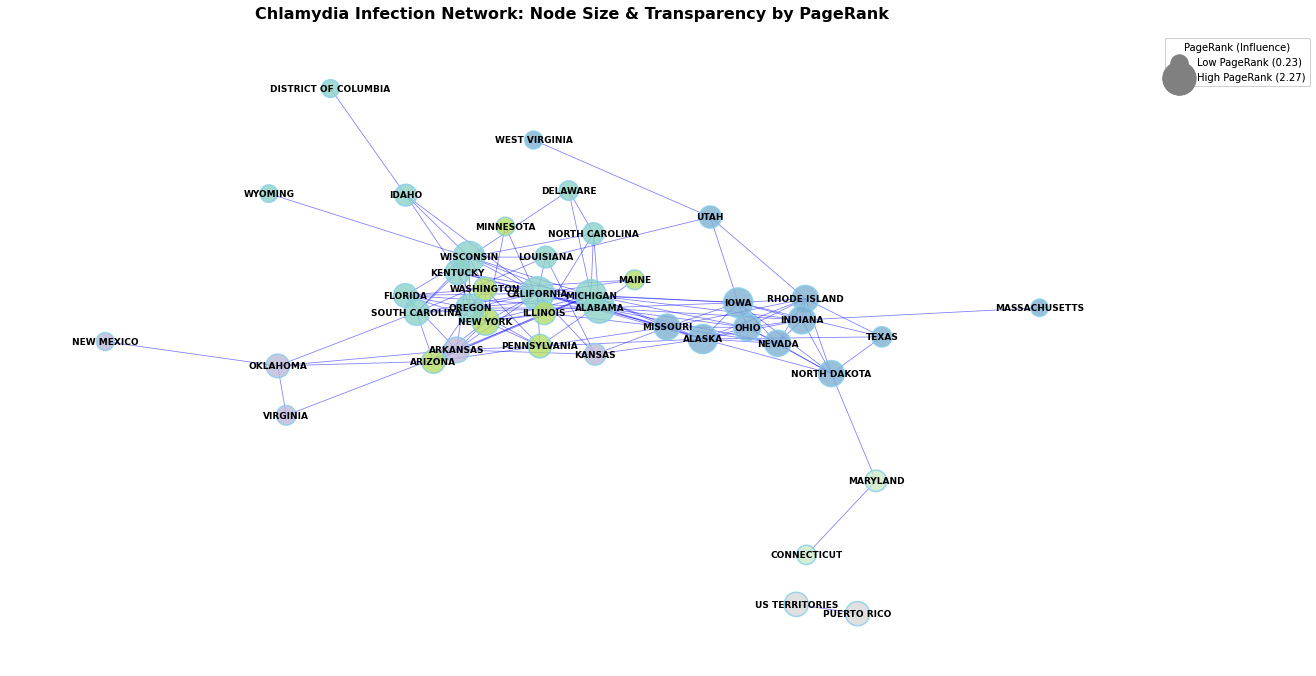

Plotted infection graph with enhanced node size and color by PageRank (and optional community).


In [59]:
# 3) Building the NetworkX Graph
infection_graph_pagerank = nx.Graph()

# If you have a DataFrame called df_infection_edges with columns [state1, state2, weight]:
for row in edge_data:
    state_a = row["stateA"]
    state_b = row["stateB"]
    similarity_weight = row["weight"]  # Keeping the weight, even if not directly visualized here
    # Ensure nodes exist
    infection_graph_pagerank.add_node(state_a)
    infection_graph_pagerank.add_node(state_b)
    # Undirected edge with weight (can be used for future weighted analyses)
    infection_graph_pagerank.add_edge(state_a, state_b, weight=similarity_weight)

print(f"Number of nodes in the PageRank graph: {infection_graph_pagerank.number_of_nodes()}")
print(f"Number of edges in the PageRank graph: {infection_graph_pagerank.number_of_edges()}")

# 4) Attach PageRank and Optional Community as Node Attributes
for node in infection_graph_pagerank.nodes():
    infection_graph_pagerank.nodes[node]["pagerank"] = dict_pagerank.get(node, 0.0)
    # If you have community info from Louvain:
    infection_graph_pagerank.nodes[node]["community"] = dict_louvain.get(node, -1)

# 5) Node Size by PageRank with Better Scaling
pagerank_values = [infection_graph_pagerank.nodes[n]["pagerank"] for n in infection_graph_pagerank.nodes()]
min_pr = min(pagerank_values)
max_pr = max(pagerank_values)

# Scale PageRank to a more visually distinct node size range
node_sizes = [(val - min_pr) / (max_pr - min_pr) * 800 + 300 for val in pagerank_values]
# Consider a square root or logarithmic scale for highly skewed distributions
# node_sizes = [300 + 800 * math.sqrt((val - min_pr) / (max_pr - min_pr)) for val in pagerank_values]

# Node Color: Enhanced Options
# Option 1: Single Color with Transparency based on PageRank
normalized_pagerank = [(val - min_pr) / (max_pr - min_pr) for val in pagerank_values]
base_color = "Yellow"
node_colors = [mcolors.to_rgba(base_color, alpha=0.5 + 0.5 * val) for val in normalized_pagerank]

# Option 2: Color by Louvain Community (if available)
if "community" in list(infection_graph_pagerank.nodes(data=True))[0][1]:
    communities = [infection_graph_pagerank.nodes[n]["community"] for n in infection_graph_pagerank.nodes()]
    unique_communities = sorted(set(communities))
    base_colormap = cm.Set3
    community_color_map = {}
    for i, comm_id in enumerate(unique_communities):
        if comm_id == -1:
            community_color_map[comm_id] = "lightgray"
        else:
            community_color_map[comm_id] = base_colormap(i / len(unique_communities))
    node_colors = [community_color_map[c] for c in communities]
else:
    print("Community data not found in graph nodes. Using single color with PageRank transparency.")

# 6) Enhanced Layout and Drawing
plt.figure(figsize=(16, 10))  # Adjust figure size for better aspect ratio
pos = nx.spring_layout(infection_graph_pagerank, k=0.3, seed=42)

nx.draw_networkx_edges(infection_graph_pagerank, pos, edge_color="blue", alpha=0.5, width=0.8)

nodes = nx.draw_networkx_nodes(
    infection_graph_pagerank,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="skyblue",
    linewidths=1.5,
    alpha=0.8
)

nx.draw_networkx_labels(
    infection_graph_pagerank,
    pos,
    font_size=9,
    font_weight="bold"
)

plt.title("Chlamydia Infection Network: Node Size & Transparency by PageRank", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Node size and transparency (or color) indicate PageRank. Edges represent similarity in infection patterns.", fontsize=10)
plt.axis("off")

# 7) Add a Legend for Node Size (PageRank)
def scatter_legend_elements(sizes, labels, color='blue'):
    return [plt.scatter([], [], s=size, color=color, label=label) for size, label in zip(sizes, labels)]

min_pr_readable = f"{min_pr:.2f}"
max_pr_readable = f"{max_pr:.2f}"

size_legend = plt.legend(
    handles=scatter_legend_elements([300, 1100], [f"Low PageRank ({min_pr_readable})", f"High PageRank ({max_pr_readable})"], color=base_color if isinstance(node_colors, str) else 'gray'),
    title="PageRank (Influence)",
    fontsize=10,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(size_legend)

# 8) Add a Legend for Community Color (if used)
if "community" in list(infection_graph_pagerank.nodes(data=True))[0][1]:
    community_labels = {id: f"Community {id}" if id != -1 else "Unassigned" for id in unique_communities}
    color_handles = [plt.plot([], [], marker="o", markersize=8, linestyle="none", color=community_color_map[id], label=label)[0]
                     for id, label in community_labels.items()]
   # plt.legend(handles=color_handles, title="Louvain Communities", fontsize=10, loc="upper left", bbox_to_anchor=(1.02, 0.7))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("chlamydia_pageRank_network.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print("Plotted infection graph with enhanced node size and color by PageRank (and optional community).")